In [1]:
from datasets.classification_dataset import DermaClassificationDataset
from pathlib import Path
import pandas as pd

def get_dataset_image_root() -> Path:
    """Returns the path to the root of the classification dataset"""
    return Path("./images/classification/")

def get_classification_csv_path() -> Path:
    """Returns the path to the csv file containing the information about the images
    and their classifications"""
    return Path("./datasets/csv_files/clean_classification_dataset.csv")


In [2]:
# from sklearn.model_selection import train_test_split
from utils.splitters import train_test_split_for_unbalanced_dataframes, reduce_the_other_category


all_images_df = pd.read_csv(get_classification_csv_path())
all_images_df = reduce_the_other_category(all_images_df, to_percentage=0.18)
# train_files, val_files = train_test_split(all_images_df, test_size=0.2, random_state=42)
train_files, test_files = train_test_split_for_unbalanced_dataframes(all_images_df, test_percentage=0.2, column_name="metaclass", seed=35)

train_files, val_files = train_test_split_for_unbalanced_dataframes(train_files, test_percentage=0.16, column_name="metaclass", seed=35)

print(f"Size of training images: {len(train_files)}")
print(f"Size of validation images: {len(val_files)}")
print(f"Size of test images: {len(test_files)}")

Size of training images: 13690
Size of validation images: 2609
Size of test images: 4078


In [3]:
from preprocessing.dataset_transforms import (
    get_classification_train_transforms_v2,
    get_classification_evaluation_transform_v2,
)

all_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=all_images_df,
    transform=None,
)

train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=None,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=None,
)

test_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=test_files,
    transform=None
)

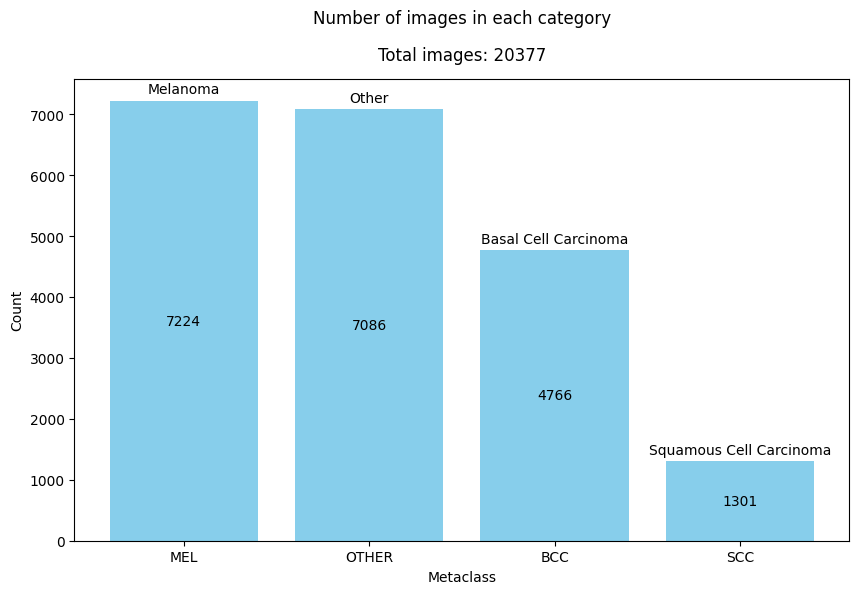

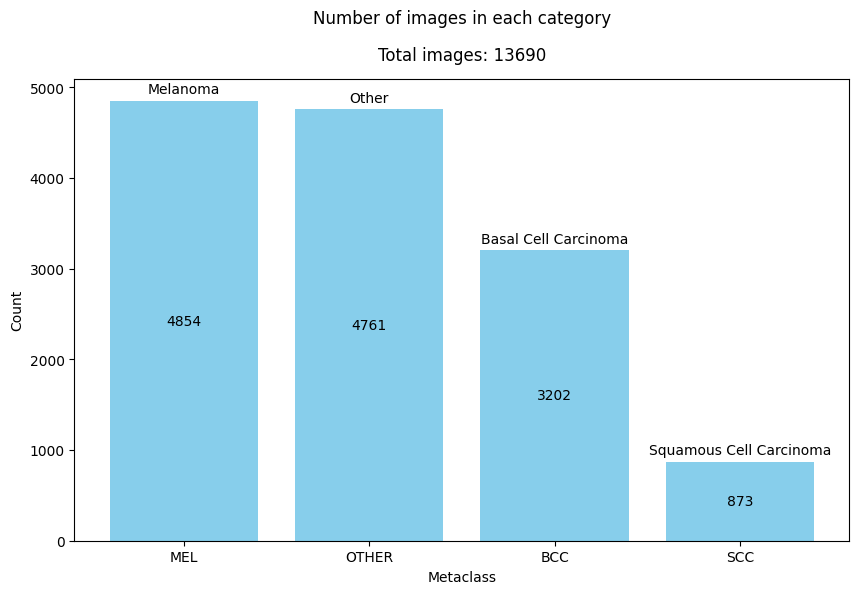

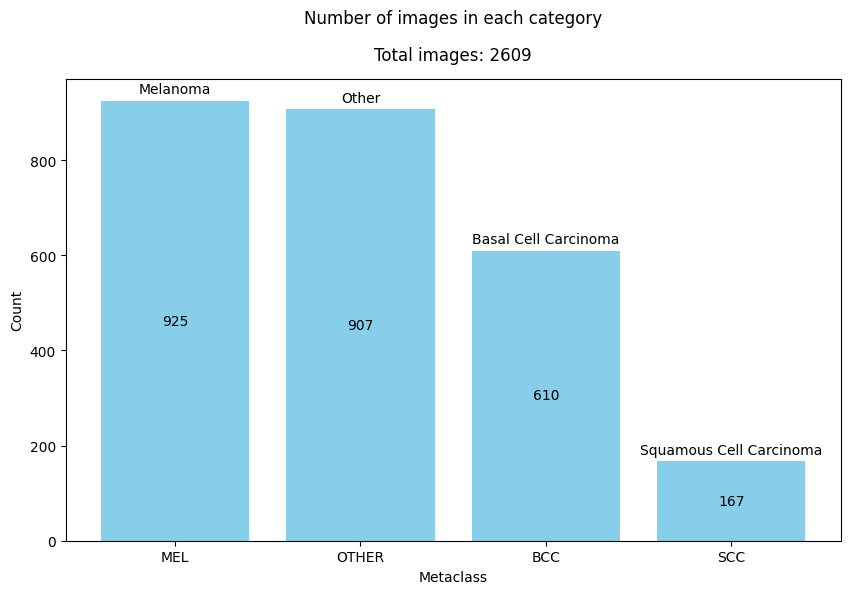

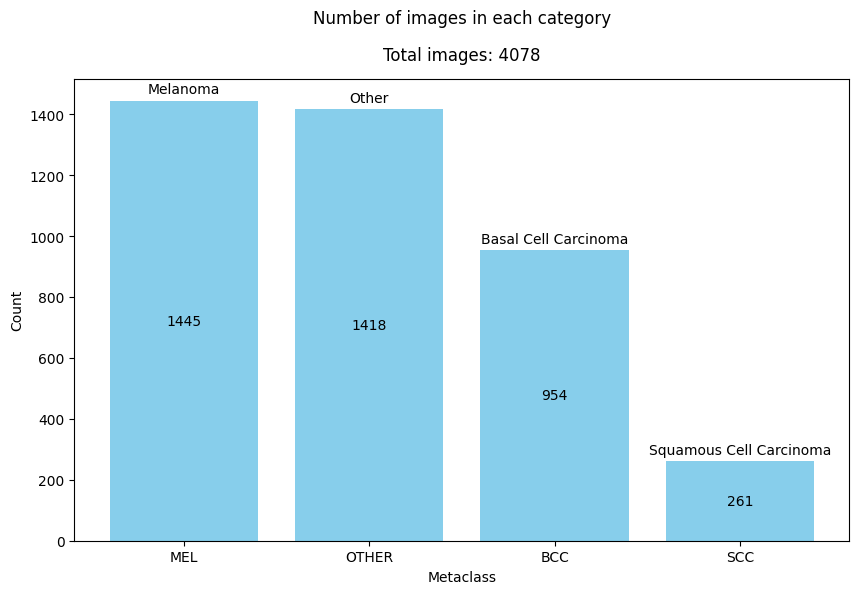

In [4]:
all_dataset.plot_class_distribution()
train_dataset.plot_class_distribution()
val_dataset.plot_class_distribution()
test_dataset.plot_class_distribution()

In [5]:
all_images_df
res = all_images_df["classification"].value_counts()
res = res.reset_index()
res.columns = ["classification", "count"]
total = res["count"].sum()
print(res)

                classification  count
0                     melanoma   7224
1                        nevus   5856
2         basal_cell_carcinoma   4766
3      squamous_cell_carcinoma   1301
4         seborrheic_keratosis    342
5            actinic_keratosis    242
6   pigmented_benign_keratosis    241
7                solar_lentigo    100
8               dermatofibroma     71
9              vascular_lesion     60
10         lichenoid_keratosis     55
11                 acrochordon     54
12                     verruca     21
13                     angioma     12
14         melanoma_metastasis      7
15             lentigo_simplex      7
16                        scar      5
17                       other      5
18                neurofibroma      4
19               angiokeratoma      2
20       sebaceous_hyperplasia      1
21        clear_cell_acanthoma      1


In [6]:
train_dl = train_dataset.get_balanced_dataloader(batch_size=32, num_workers=8)

val_dl = val_dataset.get_basic_dataloader(batch_size=32, num_workers=8)

100%|██████████| 13690/13690 [00:00<00:00, 496035.02it/s]


In [7]:
from tqdm import tqdm

def get_image_counts_by_category(dataloader):
    """
    Returns a dictionary with the count of images in each category from the given DataLoader.

    Args:
        dataloader (DataLoader): The DataLoader to analyze.

    Returns:
        dict: A dictionary where each key is a category (as an integer) and the value is the total count of images in that category.
    """
    category_counts = {}

    # Iterate over the DataLoader
    for index, batch in tqdm(enumerate(dataloader), total=len(dataloader), colour="blue", leave=True):
        _, labels = batch

        # Iterate over the labels in the batch
        for label in labels:
            label = label.item()  # Convert tensor to integer
            if label in category_counts:
                category_counts[label] += 1
            else:
                category_counts[label] = 1

    return category_counts

In [8]:
first = get_image_counts_by_category(train_dl)
second = get_image_counts_by_category(val_dl)

print(f"The first dataloader have the following distribution:\n\t{first.items()}")
print(f"The second dataloader have the following distribution:\n\t{second.items()}")

100%|██████████| 82/82 [00:12<00:00,  6.56it/s]

The first dataloader have the following distribution:
	dict_items([(1, 3430), (2, 3412), (0, 3347), (3, 3501)])
The second dataloader have the following distribution:
	dict_items([(1, 925), (0, 610), (2, 907), (3, 167)])


## Training

In [9]:
import torchsummary
import torch

In [10]:
from models.efficientnet_transfer_learning import get_device, get_efficient_net_b2, get_efficient_net_b2_transformations

device = get_device()

In [11]:
import torch

print(torch.cuda.memory_allocated()/1024**2)

0.0


In [12]:
def train_batch(x, y, model, optimizer, criteria):
    """Train a batch of data and return the loss value and accuracy"""
    model.train()
    optimizer.zero_grad()
    prediction = model(x)
    batch_loss = criteria(prediction, y)
    batch_loss.backward()
    optimizer.step()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    _, argmaxes = prediction.max(-1)
    correct_predictions = (y == argmaxes).sum().item()
    total_examples = y.size(0)
    return correct_predictions, total_examples

@torch.no_grad()
def validation_loss(x, y, model, criteria):
    """Validate a batch of data and return the loss value and the number of correct predictions"""
    model.eval()
    prediction = model(x)
    batch_loss = criteria(prediction, y)
    return batch_loss.item()

In [13]:
import shutil

def train_epochs(
    model,
    optimizer,
    criteria,
    train_dl,
    val_dl,
    device,
    epochs=10,
    save_every_epoch:int = 3,
    save_path: Path = Path("./saved_models"),
):
    if save_path.exists():
        shutil.rmtree(save_path)
    save_path.mkdir(parents=True, exist_ok=True)
    """Train the model for a number of epochs"""
    
    if device is None:
        device = get_device()
    model.to(device)

    # Initialize metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for _, batch in tqdm(
            enumerate(train_dl),
            total=len(train_dl),
            desc=f"Training epoch {epoch+1}/{epochs}, memory= {torch.cuda.memory_allocated()/1024**2}MB",
            colour="red",
        ):
            x, y = batch
            x, y = x.to(device=device), y.to(device=device)
            total_train_loss += train_batch(x, y, model, optimizer, criteria)
            correct, batch_size = accuracy(x, y, model)
            total_train_correct += correct
            total_train_samples += batch_size

        train_loss = total_train_loss / len(train_dl)
        train_accuracy = total_train_correct / total_train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.4f}")

        # Initialize validation metrics
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        for _, batch in tqdm(
            enumerate(val_dl),
            total=len(val_dl),
            desc=f"Validation on {epoch+1}/{epochs}",
            colour="green",
        ):
            x, y = batch
            x, y = x.to(device=device), y.to(device=device)
            total_val_loss += validation_loss(x, y, model, criteria)
            correct, batch_size = accuracy(x, y, model)
            total_val_correct += correct
            total_val_samples += batch_size

        val_loss = total_val_loss / len(val_dl)
        val_accuracy = total_val_correct / total_val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if (epoch + 1) in (1, epochs) or (epoch + 1) % save_every_epoch == 0:
            model.to("cpu")
            torch.save(model.state_dict(), save_path/f"model_epoch_{epoch + 1}.pth")
            model.to(device)
    return train_losses, train_accuracies, val_losses, val_accuracies

### Efficient Net


In [14]:

model, loss, optimizer = get_efficient_net_b2(num_classes=4, dropout_rate=0.4, learning_rate=1e-4)

train_transformation, validation_transform = get_efficient_net_b2_transformations()


The name of the device is cuda


In [15]:
import torch

print(torch.cuda.memory_allocated()/1024**2)

29.80810546875


In [16]:
train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=train_transformation,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=validation_transform,
)

In [17]:
train_dl = train_dataset.get_balanced_dataloader(batch_size=32, num_workers=8, pin_memory=False, drop_last=False,)
val_dl = val_dataset.get_basic_dataloader(batch_size=32, num_workers=8, pin_memory=False, drop_last=False,)

100%|██████████| 13690/13690 [00:00<00:00, 512811.55it/s]


In [28]:
train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model=model,
    device=device,
    optimizer=optimizer,
    criteria=loss,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=16,
    save_every_epoch=3,
    save_path=Path("./saved_models/efficient_net_dropout_0.4"),
)

Training epoch 1/16, memory= 137.42236328125MB: 100%|██████████| 428/428 [02:54<00:00,  2.45it/s]

Training Loss: 1.2362
Training Accuracy: 0.5023



Validation on 1/16: 100%|██████████| 82/82 [00:39<00:00,  2.08it/s]

Validation Loss: 0.9902
Validation Accuracy: 0.5937



Training epoch 2/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:06<00:00,  1.74it/s]

Training Loss: 1.0602
Training Accuracy: 0.5942



Validation on 2/16: 100%|██████████| 82/82 [00:45<00:00,  1.82it/s]

Validation Loss: 0.9326
Validation Accuracy: 0.6117



Training epoch 3/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:21<00:00,  1.64it/s]

Training Loss: 1.0109
Training Accuracy: 0.6203



Validation on 3/16: 100%|██████████| 82/82 [00:45<00:00,  1.79it/s]

Validation Loss: 0.8911
Validation Accuracy: 0.6274



Training epoch 4/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:03<00:00,  1.76it/s]

Training Loss: 0.9740
Training Accuracy: 0.6312



Validation on 4/16: 100%|██████████| 82/82 [00:44<00:00,  1.82it/s]

Validation Loss: 0.8881
Validation Accuracy: 0.6225



Training epoch 5/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:11<00:00,  1.70it/s]

Training Loss: 0.9577
Training Accuracy: 0.6456



Validation on 5/16: 100%|██████████| 82/82 [00:44<00:00,  1.86it/s]

Validation Loss: 0.9134
Validation Accuracy: 0.6117



Training epoch 6/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:06<00:00,  1.74it/s]

Training Loss: 0.9606
Training Accuracy: 0.6446



Validation on 6/16: 100%|██████████| 82/82 [00:42<00:00,  1.91it/s]

Validation Loss: 0.8772
Validation Accuracy: 0.6259



Training epoch 7/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:06<00:00,  1.74it/s]

Training Loss: 0.9409
Training Accuracy: 0.6530



Validation on 7/16: 100%|██████████| 82/82 [00:45<00:00,  1.80it/s]

Validation Loss: 0.8625
Validation Accuracy: 0.6386



Training epoch 8/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:23<00:00,  1.62it/s]

Training Loss: 0.9262
Training Accuracy: 0.6609



Validation on 8/16: 100%|██████████| 82/82 [00:49<00:00,  1.66it/s]

Validation Loss: 0.8528
Validation Accuracy: 0.6428



Training epoch 9/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:19<00:00,  1.65it/s]

Training Loss: 0.9217
Training Accuracy: 0.6666



Validation on 9/16: 100%|██████████| 82/82 [00:45<00:00,  1.80it/s]

Validation Loss: 0.8774
Validation Accuracy: 0.6355



Training epoch 10/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:19<00:00,  1.65it/s]

Training Loss: 0.9233
Training Accuracy: 0.6641



Validation on 10/16: 100%|██████████| 82/82 [00:43<00:00,  1.88it/s]

Validation Loss: 0.8657
Validation Accuracy: 0.6343



Training epoch 11/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:18<00:00,  1.65it/s]

Training Loss: 0.9254
Training Accuracy: 0.6635



Validation on 11/16: 100%|██████████| 82/82 [00:45<00:00,  1.79it/s]

Validation Loss: 0.8464
Validation Accuracy: 0.6443



Training epoch 12/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:14<00:00,  1.68it/s]

Training Loss: 0.9278
Training Accuracy: 0.6592



Validation on 12/16: 100%|██████████| 82/82 [00:46<00:00,  1.75it/s]

Validation Loss: 0.8637
Validation Accuracy: 0.6386



Training epoch 13/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:28<00:00,  1.60it/s]

Training Loss: 0.9158
Training Accuracy: 0.6651



Validation on 13/16: 100%|██████████| 82/82 [00:46<00:00,  1.77it/s]

Validation Loss: 0.8406
Validation Accuracy: 0.6451



Training epoch 14/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:26<00:00,  1.61it/s]

Training Loss: 0.9148
Training Accuracy: 0.6686



Validation on 14/16: 100%|██████████| 82/82 [00:46<00:00,  1.76it/s]

Validation Loss: 0.8450
Validation Accuracy: 0.6573



Training epoch 15/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:22<00:00,  1.63it/s]

Training Loss: 0.9181
Training Accuracy: 0.6695



Validation on 15/16: 100%|██████████| 82/82 [00:43<00:00,  1.90it/s]

Validation Loss: 0.8367
Validation Accuracy: 0.6493



Training epoch 16/16, memory= 153.65771484375MB: 100%|██████████| 428/428 [04:06<00:00,  1.74it/s]

Training Loss: 0.9170
Training Accuracy: 0.6649



Validation on 16/16: 100%|██████████| 82/82 [00:42<00:00,  1.92it/s]

Validation Loss: 0.8430
Validation Accuracy: 0.6405


In [29]:
# Now lets plot the training and validation losses
import matplotlib.pyplot as plt

def plot_training_results(train_losses, train_accuracies, val_losses, val_accuracies):
    length = len(train_losses)
    epochs_range = range(1, length + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.show()


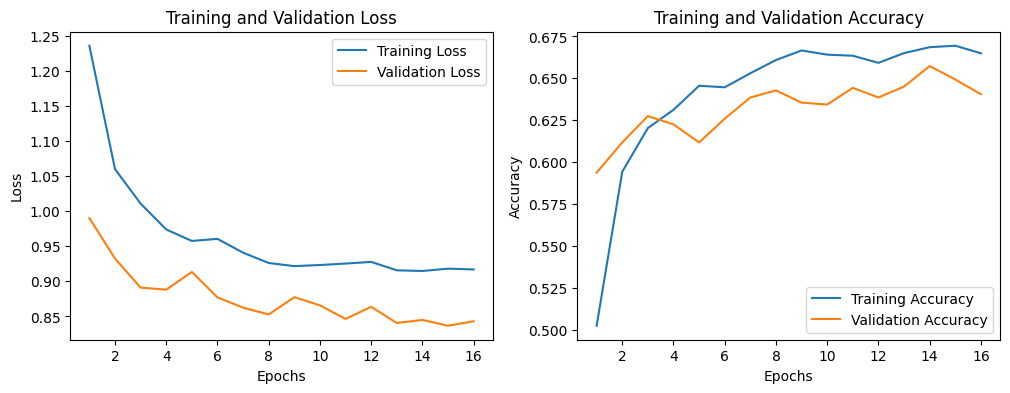

In [30]:
plot_training_results(
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
)

## Evaluacion

In [31]:
from typing import *
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from torchvision.transforms.v2 import Transform
from torch import Tensor
from PIL import Image
from tqdm import tqdm

def get_metrics(
    image_paths: list[str],
    expected_labels: list[str],
    model,
    transformation: Transform,
    idx_to_class: Callable[[int], str],
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    """
    Get the classification report and confusion matrix for a given set of images.

    Args:
        image_paths: List of image paths.
        expected_labels: List of expected labels.
        model: Trained model instance.
        idx_to_class: Function or dictionary to convert class indices to class names.
        device: Device to run the model on ("cuda" or "cpu").

    Returns:
        Tuple: The classification report and confusion matrix.
    """
    model.to(device)
    model.eval()

    # Get predictions
    predictions = []
    with torch.no_grad():
        for img_p in tqdm(image_paths, total=len(image_paths), desc="Predicting", colour="blue"):
            img = Image.open(img_p)
            img: Tensor = transformation(img)
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = idx_to_class(predicted.item())
            predictions.append(predicted_label)


    # Get classification report
    report = classification_report(expected_labels, predictions)

    # Get confusion matrix
    cm = confusion_matrix(expected_labels, predictions)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    return report, cm

In [32]:
def extract_paths_and_labels(df: pd.DataFrame) -> tuple[list[str], list[str]]:
    # Verificar que las columnas necesarias existen en el dataframe
    if 'image_path' not in df.columns or 'metaclass' not in df.columns:
        raise ValueError("El dataframe debe contener las columnas 'img_path' y 'metaclass'")
    
    # Extraer las rutas de las imágenes y las clasificaciones
    image_paths = df['image_path'].tolist()
    classifications = df['metaclass'].tolist()
    
    # Devolver la tupla de listas
    return image_paths, classifications

In [36]:
paths, labels = extract_paths_and_labels(test_files)
img_paths = [str(get_dataset_image_root() / path) for path in paths]

In [37]:
report, cm = get_metrics(
    image_paths=img_paths,
    expected_labels=labels,
    device=get_device(),
    model=model,
    transformation=validation_transform,
    idx_to_class=val_dataset.int_to_metaclass,
)

Predicting:   0%|          | 0/4078 [00:00<?, ?it/s]

Predicting: 100%|██████████| 4078/4078 [02:24<00:00, 28.22it/s]


In [38]:
print(report)

              precision    recall  f1-score   support

         BCC       0.66      0.65      0.65       954
         MEL       0.74      0.57      0.64      1445
       OTHER       0.70      0.71      0.71      1418
         SCC       0.27      0.61      0.37       261

    accuracy                           0.64      4078
   macro avg       0.59      0.63      0.59      4078
weighted avg       0.68      0.64      0.65      4078



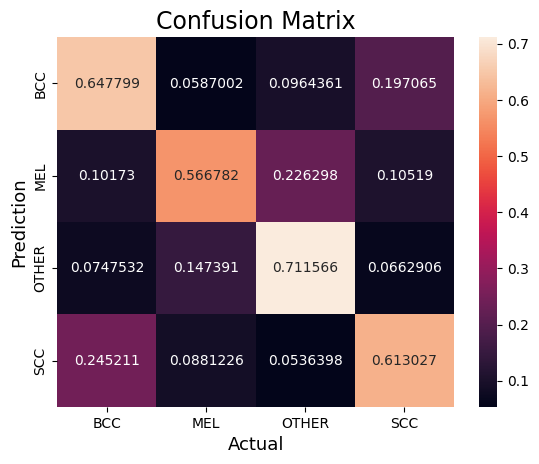

In [39]:
idx_to_class = val_dataset.int_to_metaclass

labels = [idx_to_class(i) for i in range(4)]

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()